# GD2. 이미지 어디까지 우려볼까?
- **project**: CutMix, Mixup 비교실험
    
    - Resnet50 (No Augmentation)  
    
    - Resnet50 + augmentation (기본)  
    
    - Resnet50 + CutMix   
    
    - Resnet50 + Mixup   

---
## 1. Augmentation을 적용한 데이터셋 만들기

### 1-1. 데이터 불러오기
`stanford_dogs` 데이터셋  
- 120개 견종의 이미지
- 총 20,580장 (학습용 12,000장 + 평가용 8,580장)

In [1]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import tensorflow_datasets as tfds

In [2]:
# GPU 환경 확인
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [34]:
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

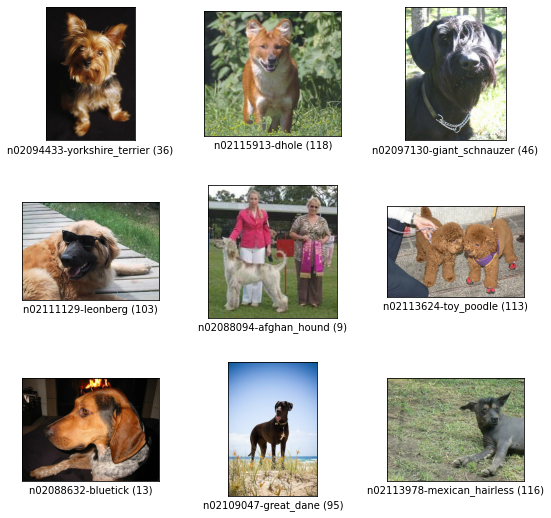

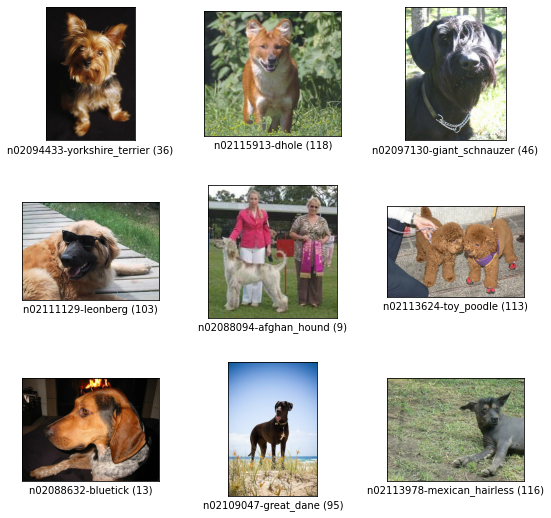

In [4]:
tfds.show_examples(ds_train, ds_info)

### 1-2. Augmentation (기본)

**Tensorflow Random Augmentation API 사용**  

- random_brightness()
- random_contrast()
- random_crop()
- random_flip_left_right()
- random_flip_up_down()
- random_hue()
- random_jpeg_quality()
- random_saturation()

In [35]:
# 전처리 함수
def normalize_and_resize_img(image, label): # 변환할 이미지와 라벨 
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [36]:
def augment(image,label):
    image = tf.image.random_flip_left_right(image) # 좌우 반전
    image = tf.image.random_brightness(image, max_delta=0.2) # 밝기 변화
    image = tf.clip_by_value(image, 0, 1)
    return image, label

In [37]:
# 데이터셋(ds)을 가공하는 메인함수
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False):
    ds = ds.map(
        normalize_and_resize_img,  # 기본적인 전처리 함수 적용
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment,       # augment 함수 적용
            num_parallel_calls=2 # 병렬처리 수준 지정
        )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)  
    # tf.data.experimental.AUTOTUNE: 어떤 수준의 병렬처리가 tf.data  런타임에 사용되는지 결정
    return ds

In [38]:
ds_train_no_aug = apply_normalize_on_dataset(ds_train, with_aug=False)

In [39]:
num_classes = ds_info.features["label"].num_classes

### 1-3. Augmentation(Cutmix)

- `CutMix`: Mixup과 비슷하지만 일정 영역을 잘라서 붙여주는 방법  


- 이미지 섞기
    - 바운딩 박스(bounding box): 이미지에서 잘라서 섞어주는 영역
    - 바운딩 박스의 위치를 랜덤하게 뽑고 잘라내서 두 개의 이미지를 섞어줌  


- 라벨 섞기
    - CutMix에서는 면적에 비례해서 라벨을 섞는다.
    - 라벨 벡터는 각 클래스에 해당하는 인덱스에 적절한 비율을 배분하는 방식 사용

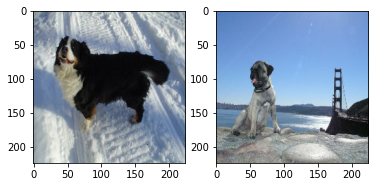

In [40]:
import matplotlib.pyplot as plt

# 데이터셋에서 이미지 2개를 가져옵니다. 
for i, (image, label) in enumerate(ds_train_no_aug.take(1)):
    if i == 0:
        image_a = image[0]
        image_b = image[1]
        label_a = label[0]
        label_b = label[1]
        break

plt.subplot(1,2,1)
plt.imshow(image_a)

plt.subplot(1,2,2)
plt.imshow(image_b)

plt.show()

In [41]:
def get_clip_box(image_a, image_b):
    # image.shape = (height, width, channel)
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0]
    
    # get center of box
    x = tf.cast(tf.random.uniform([], 0, image_size_x), tf.int32)
    y = tf.cast(tf.random.uniform([], 0, image_size_y), tf.int32)

    # get width, height of box
    width = tf.cast(image_size_x*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    height = tf.cast(image_size_y*tf.math.sqrt(1-tf.random.uniform([], 0, 1)), tf.int32)
    
    # clip box in image and get minmax bbox
    x_min = tf.math.maximum(0, x-width//2)
    y_min = tf.math.maximum(0, y-height//2)
    x_max = tf.math.minimum(image_size_x, x+width//2)
    y_max = tf.math.minimum(image_size_y, y+width//2)
    
    return x_min, y_min, x_max, y_max

In [42]:
x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)

print('x : ', x_min, x_max)
print('y : ', y_min, y_max)

x :  tf.Tensor(0, shape=(), dtype=int32) tf.Tensor(90, shape=(), dtype=int32)
y :  tf.Tensor(7, shape=(), dtype=int32) tf.Tensor(186, shape=(), dtype=int32)


In [43]:
# mix two images
def mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    middle_left = image_a[y_min:y_max, 0:x_min, :] # image_b의 왼쪽 바깥 영역
    middle_center = image_b[y_min:y_max, x_min:x_max, :]  # image_b의 안쪽 영역
    middle_right = image_a[y_min:y_max, x_max:image_size_x, :] # image_b의 오른쪽 바깥 영역
    middle = tf.concat([middle_left,middle_center,middle_right], axis=1)
    top = image_a[0:y_min, :, :]
    bottom = image_a[y_max:image_size_y, :, :]
    mixed_img = tf.concat([top, middle, bottom],axis=0)
    
    return mixed_img

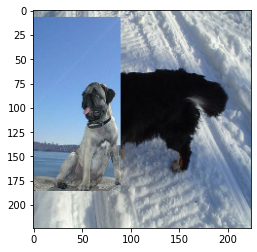

In [44]:
mixed_img = mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max)
plt.imshow(mixed_img.numpy())
plt.show()

In [45]:
# mix two labels
def mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max, num_classes=120):
    image_size_x = image_a.shape[1]
    image_size_y = image_a.shape[0] 
    mixed_area = (x_max-x_min)*(y_max-y_min)
    total_area = image_size_x*image_size_y
    ratio = tf.cast(mixed_area/total_area, tf.float32)

    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_label = (1-ratio)*label_a + ratio*label_b
    return mixed_label

In [46]:
mixed_label = mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max)
mixed_label

<tf.Tensor: shape=(120,), dtype=float32, numpy=
array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.     

In [47]:
def cutmix(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0, batch_size),tf.int32)
        image_b = image[j]
        label_b = label[j]
        x_min, y_min, x_max, y_max = get_clip_box(image_a, image_b)
        mixed_imgs.append(mix_2_images(image_a, image_b, x_min, y_min, x_max, y_max))
        mixed_labels.append(mix_2_labels(label_a, label_b, x_min, y_min, x_max, y_max))

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 1-4. Mixup Augmentation
- 두 이미지 쌍을 섞을 비율은 일정한 범위 내에서 랜덤하게 뽑는다.
- 해당 비율 값에 따라 두 이미지의 픽셀별 값과 라벨을 섞어준다.

In [48]:
# function for mixup
def mixup_2_images(image_a, image_b, label_a, label_b):
    ratio = tf.random.uniform([], 0, 1)
    
    if len(label_a.shape)==0:
        label_a = tf.one_hot(label_a, num_classes)
    if len(label_b.shape)==0:
        label_b = tf.one_hot(label_b, num_classes)
    mixed_image= (1-ratio)*image_a + ratio*image_b
    mixed_label = (1-ratio)*label_a + ratio*label_b
    
    return mixed_image, mixed_label

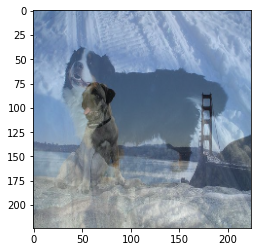

In [49]:
mixed_img2, mixed_label2 = mixup_2_images(image_a, image_b, label_a, label_b)
plt.imshow(mixed_img2.numpy())
plt.show()

In [50]:
print(mixed_label2)

tf.Tensor(
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.5049962  0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         

In [51]:
def mixup(image, label, prob=1.0, batch_size=16, img_size=224, num_classes=120):
    mixed_imgs = []
    mixed_labels = []

    for i in range(batch_size):
        image_a = image[i]
        label_a = label[i]
        j = tf.cast(tf.random.uniform([],0,batch_size), tf.int32)
        image_b = image[j]
        label_b = label[j]
        mixed_img, mixed_label = mixup_2_images(image_a, image_b, label_a, label_b)
        mixed_imgs.append(mixed_img)
        mixed_labels.append(mixed_label)

    mixed_imgs = tf.reshape(tf.stack(mixed_imgs), (batch_size, img_size, img_size, 3))
    mixed_labels = tf.reshape(tf.stack(mixed_labels), (batch_size, num_classes))
    return mixed_imgs, mixed_labels

### 1-5. 데이터셋 제작하기
cutmix, mixup augmentation이 적용 가능하도록 `apply_normalize_on_dataset` 함수 수정

In [52]:
def onehot(image, label) :
    label = tf.one_hot(label, num_classes)
    return image, label

In [53]:
def normalize_and_resize_img(image, label):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

def augment(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, max_delta=0.2)
    image = tf.image.random_hue(image, max_delta=0.2)
    image = tf.clip_by_value(image, 0, 1)
    return image, label

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16, with_aug=False, with_cutmix=False, with_mixup=False):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    if not is_test and with_aug:
        ds = ds.map(
            augment
        )
    ds = ds.batch(batch_size)
    if not is_test and with_cutmix:
        ds = ds.map(
            cutmix,
            num_parallel_calls=2
        )

    elif not is_test and with_mixup:
        ds = ds.map(
            mixup,
            num_parallel_calls=2
        )
    else:
        ds = ds.map(
            onehot,
            num_parallel_calls=2
        )

    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)

    return ds

In [54]:
ds_train_aug = apply_normalize_on_dataset(ds_train, with_aug=True)
ds_train_cutmix = apply_normalize_on_dataset(ds_train, with_cutmix=True)
ds_train_mixup = apply_normalize_on_dataset(ds_train, with_mixup=True)
ds_test = apply_normalize_on_dataset(ds_test, is_test=True)

---
## 2. 모델 만들기

### 2-1. ResNet50 (No augmentation)

In [55]:
resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 2-2. ResNet50 (augmentation)

In [56]:
aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 2-3. ResNet50 (CutMix augmentation)

In [57]:
cutmix_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

### 2-3. ResNet50 (Mixup augmentation)

In [58]:
mixup_aug_resnet50 = keras.models.Sequential([
    keras.applications.resnet.ResNet50(
        include_top=False,
        weights='imagenet',
        input_shape=(224,224,3),
        pooling='avg',
    ),
    keras.layers.Dense(num_classes, activation='softmax')
])

---

## 3. 모델 훈련하기

### 3-1. ResNet50 (No augmentation)

In [59]:
EPOCH = 20

In [30]:
resnet50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_no_aug = resnet50.fit(
    ds_train_no_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 377s 433ms/step - loss: 3.1511 - accuracy: 0.2831 - val_loss: 3.2059 - val_accuracy: 0.2311
Epoch 2/20
750/750 [==============================] - 324s 432ms/step - loss: 0.9234 - accuracy: 0.7430 - val_loss: 1.1888 - val_accuracy: 0.6540
Epoch 3/20
750/750 [==============================] - 324s 433ms/step - loss: 0.3161 - accuracy: 0.9240 - val_loss: 0.9921 - val_accuracy: 0.7078
Epoch 4/20
750/750 [==============================] - 325s 433ms/step - loss: 0.1016 - accuracy: 0.9864 - val_loss: 0.9387 - val_accuracy: 0.7334
Epoch 5/20
750/750 [==============================] - 325s 434ms/step - loss: 0.0333 - accuracy: 0.9983 - val_loss: 0.9337 - val_accuracy: 0.7364
Epoch 6/20
750/750 [==============================] - 331s 441ms/step - loss: 0.0249 - accuracy: 0.9990 - val_loss: 0.9555 - val_accuracy: 0.7374
Epoch 7/20
750/750 [==============================] - 325s 433ms/step - loss: 0.0147 - accuracy: 0.9999 - val_loss: 0.9684 -

### 3-2. ResNet50 (augmentation)

In [60]:
aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_aug = aug_resnet50.fit(
    ds_train_aug, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 334s 433ms/step - loss: 3.2744 - accuracy: 0.2651 - val_loss: 2.8762 - val_accuracy: 0.2938
Epoch 2/20
750/750 [==============================] - 324s 433ms/step - loss: 1.1844 - accuracy: 0.6621 - val_loss: 1.2106 - val_accuracy: 0.6460
Epoch 3/20
750/750 [==============================] - 325s 433ms/step - loss: 0.6809 - accuracy: 0.8063 - val_loss: 1.0930 - val_accuracy: 0.6793
Epoch 4/20
750/750 [==============================] - 331s 442ms/step - loss: 0.3836 - accuracy: 0.8981 - val_loss: 1.1155 - val_accuracy: 0.6847
Epoch 5/20
750/750 [==============================] - 325s 433ms/step - loss: 0.2054 - accuracy: 0.9564 - val_loss: 0.9633 - val_accuracy: 0.7284
Epoch 6/20
750/750 [==============================] - 324s 432ms/step - loss: 0.1273 - accuracy: 0.9765 - val_loss: 1.0255 - val_accuracy: 0.7203
Epoch 7/20
750/750 [==============================] - 324s 432ms/step - loss: 0.0726 - accuracy: 0.9897 - val_loss: 0.9734 -

### 3-3. ResNet50 (CutMix augmentation)

In [61]:
cutmix_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_cutmix = cutmix_aug_resnet50.fit(
    ds_train_cutmix, 
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 338s 437ms/step - loss: 4.3438 - accuracy: 0.1112 - val_loss: 3.2479 - val_accuracy: 0.2315
Epoch 2/20
750/750 [==============================] - 326s 435ms/step - loss: 3.0513 - accuracy: 0.4074 - val_loss: 1.3807 - val_accuracy: 0.6178
Epoch 3/20
750/750 [==============================] - 326s 435ms/step - loss: 2.7177 - accuracy: 0.5071 - val_loss: 1.2365 - val_accuracy: 0.6543
Epoch 4/20
750/750 [==============================] - 325s 433ms/step - loss: 2.4417 - accuracy: 0.5966 - val_loss: 1.4033 - val_accuracy: 0.6174
Epoch 5/20
750/750 [==============================] - 325s 434ms/step - loss: 2.3127 - accuracy: 0.6376 - val_loss: 1.3028 - val_accuracy: 0.6431
Epoch 6/20
750/750 [==============================] - 326s 434ms/step - loss: 2.1868 - accuracy: 0.6781 - val_loss: 1.1511 - val_accuracy: 0.6874
Epoch 7/20
750/750 [==============================] - 325s 434ms/step - loss: 2.0890 - accuracy: 0.7097 - val_loss: 1.2599 -

### 3-4. ResNet50 (Mixup augmentation)

In [63]:
mixup_aug_resnet50.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(lr=0.01),
    metrics=['accuracy'],
)

history_resnet50_mixup = mixup_aug_resnet50.fit(
    ds_train_mixup,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/20
750/750 [==============================] - 335s 435ms/step - loss: 4.2866 - accuracy: 0.1264 - val_loss: 3.9164 - val_accuracy: 0.1266
Epoch 2/20
750/750 [==============================] - 326s 434ms/step - loss: 2.9646 - accuracy: 0.4474 - val_loss: 1.3567 - val_accuracy: 0.6236
Epoch 3/20
750/750 [==============================] - 325s 434ms/step - loss: 2.6197 - accuracy: 0.5651 - val_loss: 1.5346 - val_accuracy: 0.5714
Epoch 4/20
750/750 [==============================] - 326s 434ms/step - loss: 2.3893 - accuracy: 0.6415 - val_loss: 1.4440 - val_accuracy: 0.6014
Epoch 5/20
750/750 [==============================] - 325s 434ms/step - loss: 2.2904 - accuracy: 0.6881 - val_loss: 1.2386 - val_accuracy: 0.6538
Epoch 6/20
750/750 [==============================] - 325s 434ms/step - loss: 2.1857 - accuracy: 0.7315 - val_loss: 1.2543 - val_accuracy: 0.6539
Epoch 7/20
750/750 [==============================] - 325s 434ms/step - loss: 2.0886 - accuracy: 0.7631 - val_loss: 1.2337 -

---

## 4. 훈련 과정 시각화하기

훈련 과정의 히스토리를 그래프로 시각화

### 4-1. Accuracy (val)

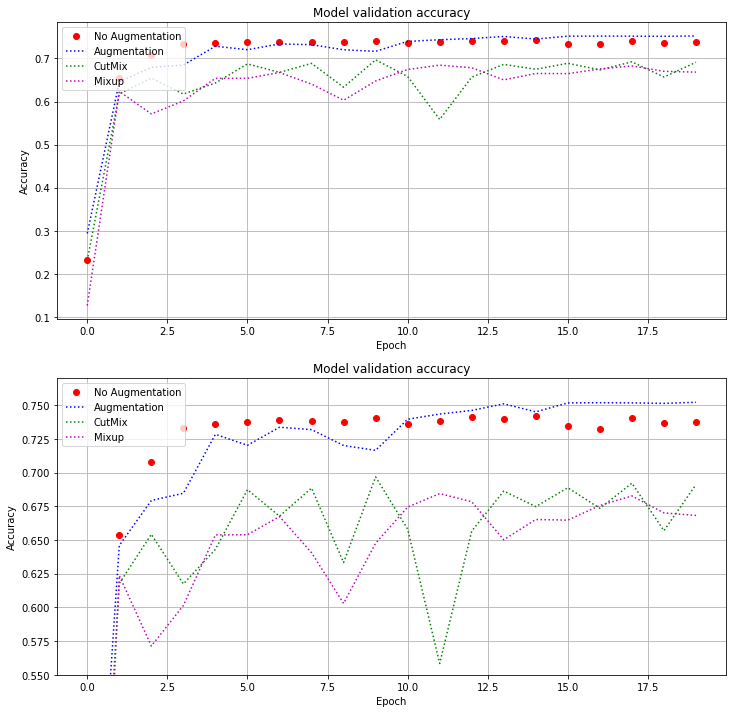

In [88]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'ro')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g:')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm:')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history_resnet50_no_aug.history['val_accuracy'], 'ro')
plt.plot(history_resnet50_aug.history['val_accuracy'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_accuracy'], 'g:')
plt.plot(history_resnet50_mixup.history['val_accuracy'], 'm:')

plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.55, 0.770)   

plt.show()

### 4-2. Loss (val)

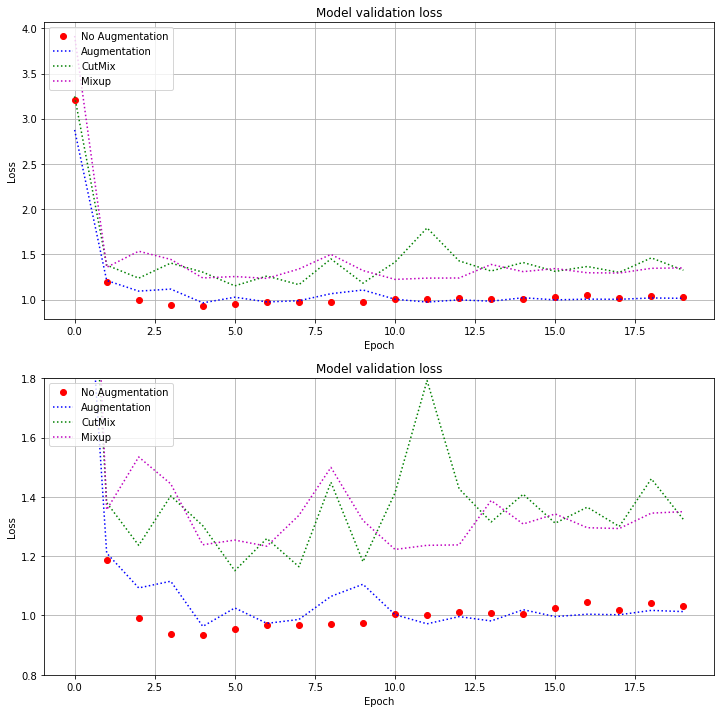

In [87]:
# 훈련 과정 시각화
plt.figure(figsize=(12, 12))

plt.subplot(2, 1, 1)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'ro')
plt.plot(history_resnet50_aug.history['val_loss'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g:')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm:')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(history_resnet50_no_aug.history['val_loss'], 'ro')
plt.plot(history_resnet50_aug.history['val_loss'], 'b:')
plt.plot(history_resnet50_cutmix.history['val_loss'], 'g:')
plt.plot(history_resnet50_mixup.history['val_loss'], 'm:')

plt.title('Model validation loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['No Augmentation', 'Augmentation', 'CutMix', 'Mixup'], loc='upper left')
plt.grid(True)
plt.ylim(0.80, 1.80)  
plt.show()

plt.show()

---

## 5. Augmentation에 의한 모델 성능 비교
- 4가지 경우의 데이터셋에 대해 훈련된 ResNet50 분류기의 견종 분류 정확도 성능을 비교
- Augmentation 방법들의 영향도에 대해 분석


### 5-1. Accuracy (val)

In [82]:
val_acc_dict = {'No Augmentation': history_resnet50_no_aug.history['val_accuracy'], 
            'Augmentation': history_resnet50_aug.history['val_accuracy'], 
            'CutMix': history_resnet50_cutmix.history['val_accuracy'], 
            'Mixup': history_resnet50_mixup.history['val_accuracy']}
df1 = pd.DataFrame(val_acc_dict)
df1

,No Augmentation,Augmentation,CutMix,Mixup
0,0.231110,0.293843,0.231460,0.126632
1,0.654034,0.645989,0.617770,0.623601
2,0.707789,0.679338,0.654268,0.571362
3,0.733442,0.684702,0.617421,0.601446
4,0.736357,0.728428,0.643074,0.653801
5,0.737407,0.720266,0.687383,0.653918
6,0.738806,0.733675,0.667677,0.667444
7,0.738456,0.731926,0.688549,0.640625
8,0.737757,0.720149,0.633279,0.602962
9,0.740322,0.716534,0.696828,0.647621


In [85]:
acc_mean = df1.mean()
acc_mean

No Augmentation    0.706734
Augmentation       0.706961
CutMix             0.638724
Mixup              0.625181
dtype: float64

### 5-2. Loss (val)

In [89]:
val_loss_dict = {'No Augmentation': history_resnet50_no_aug.history['val_loss'], 
            'Augmentation': history_resnet50_aug.history['val_loss'], 
            'CutMix': history_resnet50_cutmix.history['val_loss'], 
            'Mixup': history_resnet50_mixup.history['val_loss']}
df2 = pd.DataFrame(val_loss_dict)
df2

,No Augmentation,Augmentation,CutMix,Mixup
0,3.205862,2.876170,3.247904,3.916433
1,1.188766,1.210552,1.380711,1.356664
2,0.992061,1.092978,1.236523,1.534618
3,0.938667,1.115533,1.403337,1.443967
4,0.933708,0.963257,1.302801,1.238571
5,0.955501,1.025469,1.151145,1.254316
6,0.968375,0.973439,1.259895,1.233726
7,0.967242,0.986597,1.164474,1.337762
8,0.970460,1.064506,1.449411,1.499528
9,0.973729,1.105399,1.181528,1.320572


In [90]:
loss_mean = df2.mean()
loss_mean

No Augmentation    1.114812
Augmentation       1.120972
CutMix             1.444879
Mixup              1.457870
dtype: float64

### 5-3. 전체 비교 하기
결과를 종합적으로 비교해보면 `augmentation`-`no augmentation`-`cutmix`-`mixup` 순서로 결과가 좋았다.  

  
|No.|기준|No Augmentation|Augmentation|CutMix|Mixup|
|:---|:---|:---|:---|:---|:---|
|1|start_accuracy|1|2|3|4|
|2|end_accuracy|2|1|3|4|
|3|mean_accuracy|2|1|3|4|
|4|mean_loss|1|2|3|4|



---
## 평가 및 회고

### 루브릭

|평가문항|상세기준|
|:--|:--|
|1. CutMix와 MixUp 기법을 ResNet50 분류기에 성공적으로 적용하였는가?|CutMix와 MixUp을 적용한 데이터셋으로 훈련한 각각의 ResNet 모델이 수렴하였다.|
|2. 다양한 실험을 통해 태스크에 최적인 Augmentation 기법을 찾아내었는가?|Augmentation 적용을 통해 Augmentaion 미적용시 대비 5% 이상의 성능향상을 확인함|
|3. 여러가지 Augmentation 기법을 적용한 결과를 체계적으로 비교분석하였는가?|Augmentation, CutMix, MixUp이 적용된 결과를 시각화와 함께 체계적으로 분석하였다.|

### 회고

인내가 필요했던 프로젝트!  

학습 시간이 오래걸리고 shape이랑 onehot 함수로 인한 오류가 발생한 것 말고는 나름 괜찮았던 프로젝트였던 것 같다.  

그리고 의외로 기본적인 augmentation를 적용한 결과가 가장 좋은 것이 흥미로웠다.  

cutmix, mixup의 결과가 왜 더 안 좋을지는 생각을 좀 더 해봐야할 것 같다.  

이번 프로젝트를 통해 augmentation에 대해서 많이 알게 된 것 같아서 좋았다.  

더 공부해봐야겠다!  

----
## 참고 자료

[tf.one_hot](https://www.tensorflow.org/api_docs/python/tf/one_hot)  
[[Tensorflow][기초] one_hot함수 소개 및 실습](https://m.blog.naver.com/PostView.naver?isHttpsRedirect=true&blogId=wideeyed&logNo=221164692553)